<img src="https://raw.githubusercontent.com/andre-marcos-perez/ebac-course-utils/main/media/logo/newebac_logo_black_half.png" alt="ebac-logo">

---


# **Tópicos**

<ol type="1">
  <li>Contexto;</li>
  <li>Arquitetura;</li>
  <li>Ingestão.</li>
  <li>Configuração do Telegram.</li>
  <li>ETL.</li>
  <li>Apresentação</li>
</ol>

---

# **Projeto: Pipeline de Dados do Telegram**

# **1. Contexto:**

O **Telegram** é uma plataforma de mensagens instantâneas freeware (distribuído gratuitamente) e, em sua maioria, open source. É muito popular entre desenvolvedores por ser pioneiro na implantação da funcionalidade de criação de chatbots, que, por sua vez, permitem a criação de diversas automações.

Um **chatbot** é um tipo de software que interage com usuários através de conversas automatizadas em plataformas de mensagens. Uma aplicação comum de chatbots é o seu uso no atendimento ao cliente, onde, de maneira geral, ajudam clientes a resolver problemas ou esclarecer dúvidas recorrentes antes mesmo que um atendente humano seja acionado.

Neste projeto, vamos construir um **pipeline de dados** que ingira, processe, armazene e exponha mensagens de um grupo do Telegram e levar esses dados para um ambiente analítico. A arquitetura será dividida em duas: ***transacional***, no Telegram, onde os dados são produzidos, e ***analítica***, na Amazon Web Services Athena (AWS), onde os dados serão analisados.

### **1.1 Arquitetura**

A seguir, temos uma imagem para ilustrar a arquitetura da pipeline e os recursos que serão utilizados em mais detalhes.

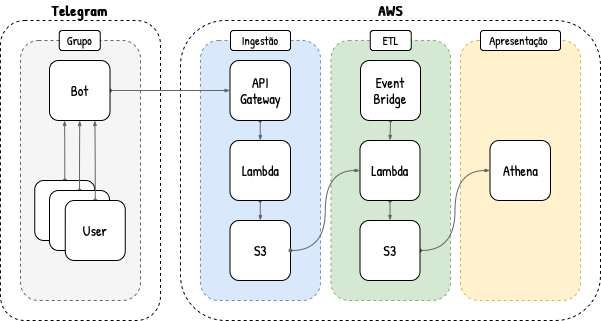


* **Telegram**

O Telegram representa a fonte de dados transacionais. Mensagens enviadas por usuários em um grupo são capturadas por um bot e redirecionadas via webhook do backend do aplicativo para um endpoint (endereço web que aceita requisições HTTP) exposto pelo AWS API Gateway. As mensagens trafegam no corpo ou payload da requisição.

* **AWS | Ingestão**

Uma requisição HTTP com o conteúdo da mensagem em seu payload é recebia pelo AWS API Gateway que, por sua vez, as redireciona para o AWS Lambda, servindo assim como seu gatilho. Já o AWS Lambda recebe o payload da requisição em seu parâmetro event, salva o conteúdo em um arquivo no formato JSON (original, mesmo que o payload) e o armazena no AWS S3 particionado por dia.

* **AWS | ETL**

Uma vez ao dia, o AWS Event Bridge aciona o AWS Lambda que processa todas as mensagens do dia anterior (atraso de um dia ou D-1), denormaliza o dado semi-estruturado típico de arquivos no formato JSON, salva o conteúdo processado em um arquivo no formato Apache Parquet e o armazena no AWS S3 particionado por dia.

* **AWS | Apresentação**

Por fim, uma tabela do AWS Athena é apontada para o bucket do AWS S3 que armazena o dado processado: denormalizado, particionado e orientado a coluna. Profissionais de dados podem então executar consultas analíticas (agregações, ordenações, etc.) na tabela utilizando o SQL para a extração de insights.

# **2. Telegram**

O **Telegram** representa a fonte transacional de dados do nosso *pipeline* de dados. Nesta etapa, vamos criar um grupo, criar um **bot** e adiciona-lo ao grupo recém criado. O *bot* então captará **todas** as mensagens enviadas no grupo. As mensagens pode ser acessadas através da **API** (*application programming interface*) de *bots* dos **Telegram** (documentação neste [link](https://core.telegram.org/bots/api)).

### **2.1 Bot**

**Após criar uma conta no Telegram, seguimos o passo-a-passo abaixo para a criaçao e ativação do bot:**

1. Abra o chat com o BotFather;
2. Digitar /newbot;
3. Digitar o nome do bot;
4. Digitar o nome de usuário do bot (terminar com sufixo _bot);
5. Salvar o token de acesso a API HTTP em um local seguro.
6. Abra o chat com o bot;
7. Selecione start.

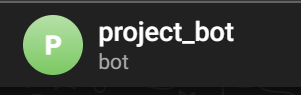!

### **2.2 Grupo**

**Nesta etapa, criamos um grupo e adicionamos o bot como administrador para que ele possa receber todas as mensagens do grupo. Por fim, configuramos o bot para que ele não possa ser adicionado a outros grupos**


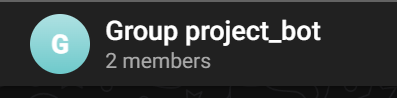

### **2.3 Bot API**

As mensagens captadas por um bot podem ser acessadas via API. Portanto, vamos utilizar a **API** de bots do Telegram para consumir estas informações, utilizando o token de acesso fornecido pelo ***BotFather*** na criação do bot.

> **Nota:** A documentação completa da API pode ser encontrada neste [link](https://core.telegram.org/bots/api)

In [ ]:
# Acesso através do token

from getpass import getpass

token = getpass()

··········


* A **url** base é comum a todos os métodos da API.

In [ ]:
import json
import requests

base_url = f'https://api.telegram.org/bot{token}'

* Uitlizamos o método `getMe` e `getUpdates` para retornar informações e mensagens do bot.

In [ ]:
response = requests.get(url=f'{base_url}/getMe')
print(f'{base_url}/getMe')

print(json.dumps(json.loads(response.text), indent=2))

https://api.telegram.org/bot6865927946:AAE7bcVgDLPYSe8CwUxMLkfzLEcQ2dgVT8I/getMe
{
  "ok": true,
  "result": {
    "id": 6865927946,
    "is_bot": true,
    "first_name": "project_bot",
    "username": "project_pipe_bot",
    "can_join_groups": true,
    "can_read_all_group_messages": true,
    "supports_inline_queries": false
  }
}


In [ ]:
# GetUpdates

response = requests.get(url=f'{base_url}/getUpdates')
print(json.dumps(json.loads(response.text), indent=2))

{
  "ok": true,
  "result": [
    {
      "update_id": 233556984,
      "my_chat_member": {
        "chat": {
          "id": -1001968380054,
          "title": "Group project_bot",
          "type": "supergroup"
        },
        "from": {
          "id": 5086492793,
          "is_bot": false,
          "first_name": "Vida Valessa",
          "language_code": "en"
        },
        "date": 1704381070,
        "old_chat_member": {
          "user": {
            "id": 6865927946,
            "is_bot": true,
            "first_name": "project_bot",
            "username": "project_pipe_bot"
          },
          "status": "member"
        },
        "new_chat_member": {
          "user": {
            "id": 6865927946,
            "is_bot": true,
            "first_name": "project_bot",
            "username": "project_pipe_bot"
          },
          "status": "administrator",
          "can_be_edited": false,
          "can_manage_chat": true,
          "can_change_info": false,
  

# **3. Ingestão**

In [ ]:
{
  "update_id": 103926030,
  "my_chat_member": {
    "chat": {
      "id": -4027852886,
      "title": "Group Chat Bot",
      "type": "group",
      "all_members_are_administrators": false
    },
    "from": {
      "id": 5086492793,
      "is_bot": false,
      "first_name": "Vida Valessa",
      "language_code": "en"
    },
    "date": 1704372901,
    "old_chat_member": {
      "user": {
        "id": 6420945163,
        "is_bot": true,
        "first_name": "Analytic_Bot",
        "username": "Analytic_data_Bot"
      },
      "status": "left"
    },
    "new_chat_member": {
      "user": {
        "id": 6420945163,
        "is_bot": true,
        "first_name": "Analytic_Bot",
        "username": "Analytic_data_Bot"
      },
      "status": "member"
    }
  }
}

Nesta etapa, iremos fazer a ingestão de dados transacionais no embiente analitico. Esta ingestão será feita no fromato `Streaming `que sáo quando os dados são ingeridos conforme são produzidos e disponibilizados, pois as mensagens capturadas pelo bot podem ser ingeridas através da API web de bots do Telegram, portanto são fornecidos no ***formato JSON***. Como o Telegram retem mensagens por apenas 24h em seus servidores, a ingestão via streaming é a mais indicada.



> Persistir os dados em seu formato original trás muitas vantagens, como a possibilidade de reprocessamento.

Esta abordagem de ingestão de dados em tempo real é importante para manter a integridade e a atualidade das informações transacionais. A combinação de tecnologias como `webhooks, AWS API Gateway, AWS Lambda e AWS S3` oferece uma solução mais escalável para as necessidades de processamento de dados do projeto. A seguir, apresentamos uma descrição detalhada mais detalhada sobre esse processo.

**Fonte de Dados: Telegram Bot**

* Os dados transacionais serão adquiridos a partir das mensagens capturadas pelo bot do Telegram.
* As mensagens do bot são disponibilizadas através da API Web do Telegram, sendo fornecidas no formato JSON.
* É importante notar que o Telegram armazena mensagens em seus servidores por um período limitado de 24 horas. Portanto, a ingestão de dados via streaming é essencial para garantir a captura oportuna e completa das informações.




**Mecanismo de Ingestão: Webhook e AWS API Gateway**

* Para facilitar esse processo, implementaremos um webhook, que é um método de redirecionamento automático de mensagens para uma API web específica.
* Utilizaremos um serviço da Amazon Web Services (AWS), especificamente o AWS API Gateway, para receber os dados redirecionados pelo webhook. Mais informações sobre o AWS API Gateway podem ser encontradas na documentação [link](https://docs.aws.amazon.com/pt_br/apigateway/latest/developerguide/welcome.html).

**Processamento e Armazenamento de Dados**

* Após a recepção dos dados pelo AWS API Gateway, eles serão conectados ao AWS Lambda.
* O AWS Lambda processará os dados, mantendo-os em seu formato original (JSON).
* Finalmente, os dados serão armazenados em um bucket do AWS S3 para análise e uso posterior.

### **3.1 AWS S3**

Nesta etapa da ingestão, vamos criar um bucket no `AWS S3` para armazenas as mensagens captadas pelo bot no seu fromato original (***JSON***). Como padrão, adicionamos o sufixo `-raw ` no seu nome.  



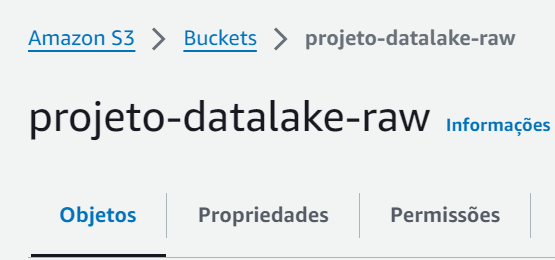

### **3.2 AWS Lambda**

Nesta etapa, vamos criar uma função no `AWS Lambda `para persistir as mesnagens captadas pelo bot em um bucket do ***AWS S3***. Neste contexto, ele irá operar da seguinte forma:




* Receber a mensagem no parâmetro event;
* Verificar se a mensagem tem origem no grupo do Telegram correto;
* Persistir a mensagem no formato JSON no bucket do AWS S3;
* Retornar uma mensagem de sucesso (código de retorno HTTP igual a 200) a API de bots do Telegram.
* Configurar duas variáveis de ambiente: `AWS_S3_BUCKET` com o nome do bucket do AWS S3 e `TELEGRAM_CHAT_ID `com o id do chat do grupo do Telegram.
* Por fim, adicionar a permissão de escrita no bucket do AWS S3 para a função do AWS Lambda no `AWS IAM`.

**Código da função:**

In [ ]:
import os
import json
import logging
from datetime import datetime, timezone, timedelta

import boto3


def lambda_handler(event: dict, context: dict) -> dict:


  # vars de ambiente

  BUCKET = os.environ['AWS_S3_BUCKET']
  TELEGRAM_CHAT_ID = int(os.environ['TELEGRAM_CHAT_ID'])

  # vars lógicas

  tzinfo = timezone(offset=timedelta(hours=-3))
  date = datetime.now(tzinfo).strftime('%Y-%m-%d')
  timestamp = datetime.now(tzinfo).strftime('%Y%m%d%H%M%S%f')
  filename = f'{timestamp}.json'

  # código principal

  client = boto3.client('s3')

  try:

    # message = json.loads(event["body"])
    message = event
    chat_id = message["message"]["chat"]["id"]

    if chat_id == TELEGRAM_CHAT_ID:

      with open(f"/tmp/{filename}", mode='w', encoding='utf8') as fp:
        json.dump(message, fp)

      client.upload_file(f'/tmp/{filename}', BUCKET, f'telegram/context_date={date}/{filename}')

  except Exception as exc:
      logging.error(msg=exc)
      return dict(statusCode="500")

  else:
      return dict(statusCode="200")

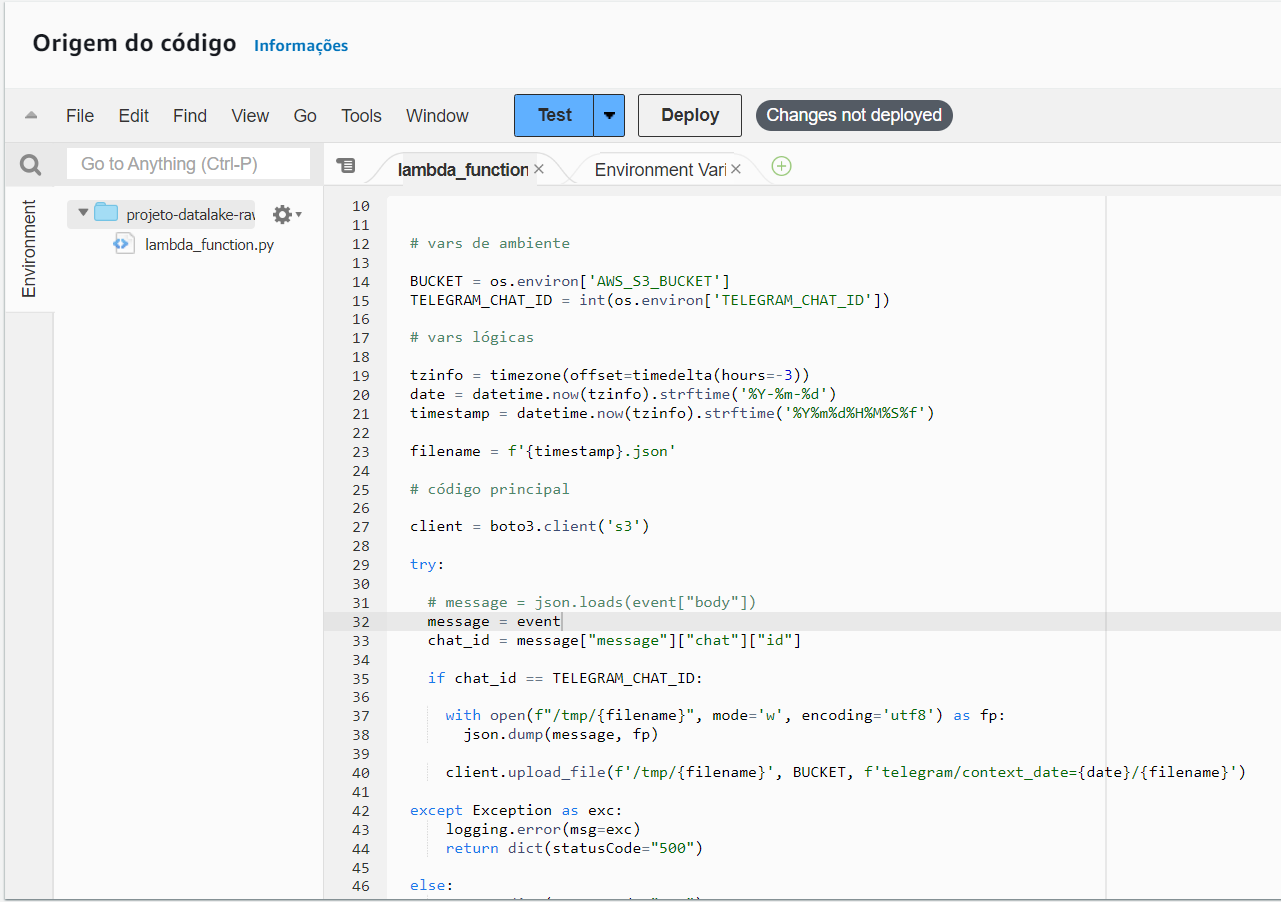

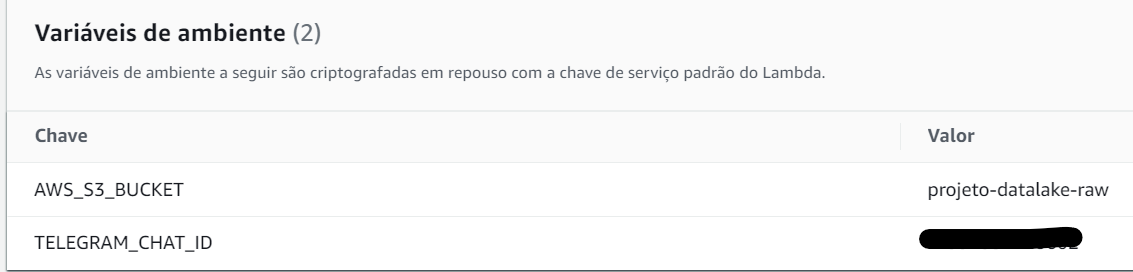

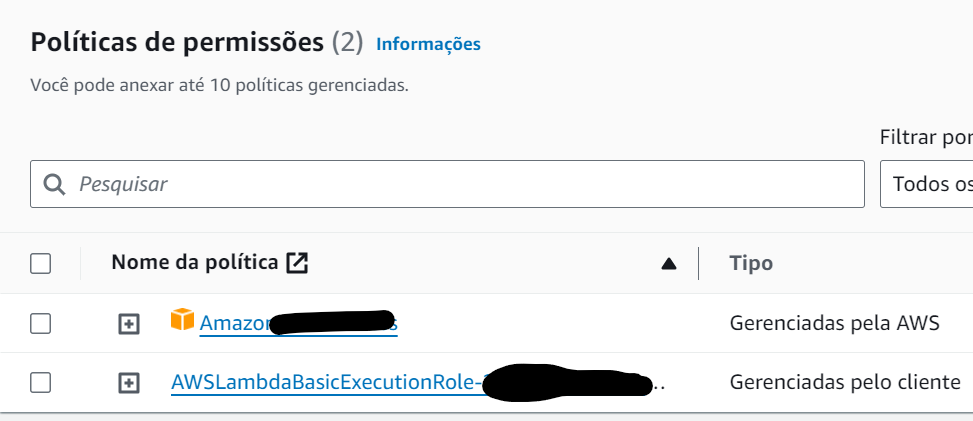

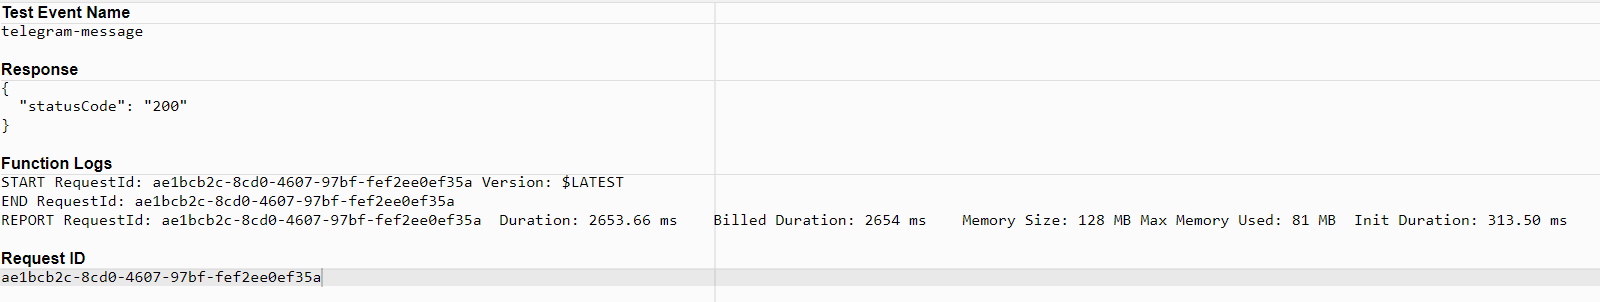

### **3.3 AWS API Gateway**

O `AWS API` Gateway tem a função de receber as mensagens captadas pelo bot do Telegram, enviadas via webhook, e iniciar uma função do AWS Lambda, passando o conteúdo da mensagem no seu parâmetro event. Nesta etapa, vamos ***criar uma API*** e configura-la como gatilho da função do AWS Lambda, abaixo consta o processo em detalhes:




Iniciamos criando a API e nomeando-a com um padrão que termina em '-api'. Configuramos um método 'POST' com integração de proxy do Lambda, selecionando a função Lambda adequada. Testamos a integração e, após a verificação, realizamos a implantação da API em um novo estágio de desenvolvimento nomeado 'dev', obtendo assim seu endereço web.


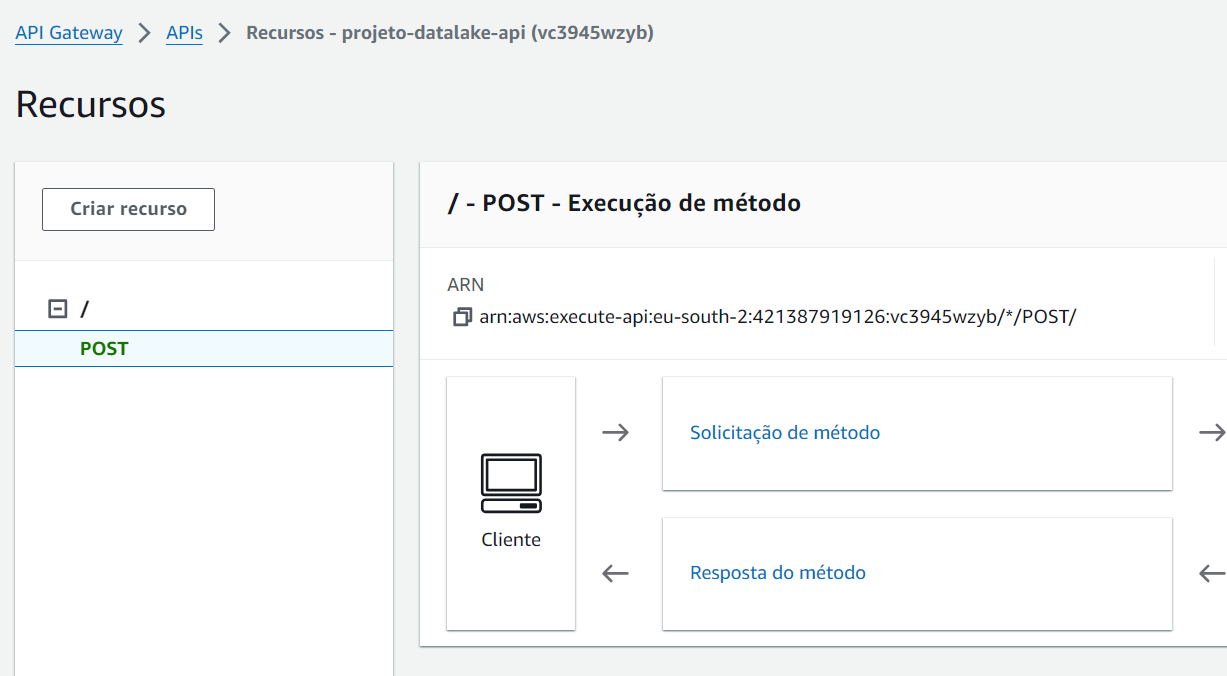

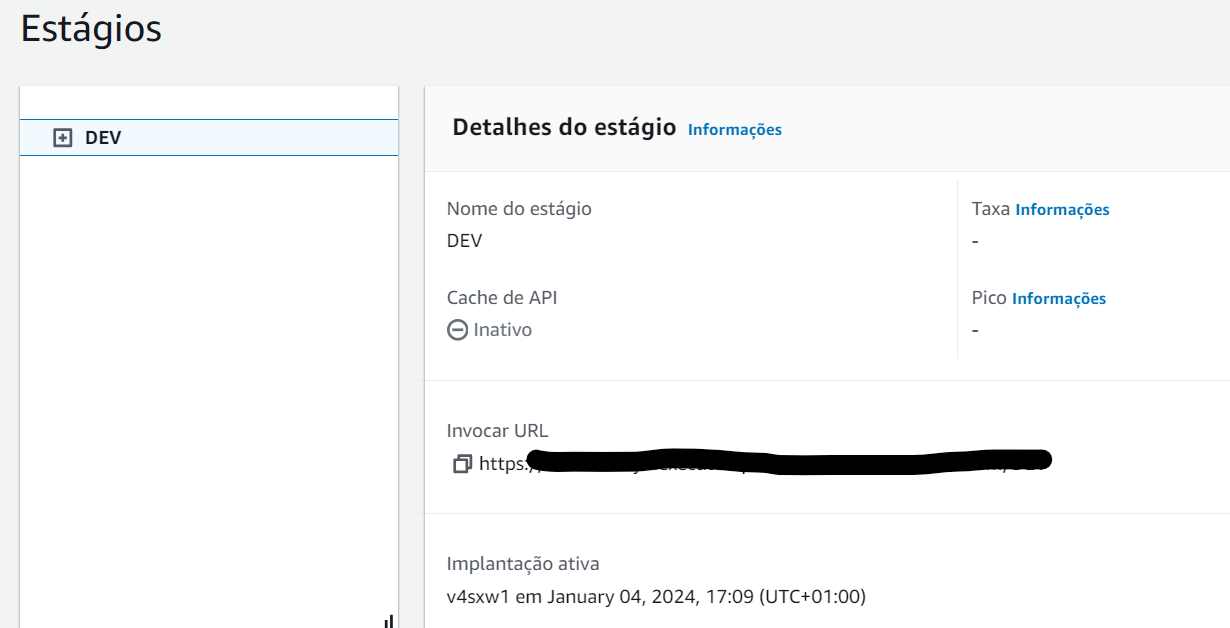

* **Copiamos a url gerada na variável `aws_api_gateway_url.`**

In [44]:
aws_api_gateway_url = getpass()

··········


# **4. Configuração do Telegram**

O método `setWebhook` configura o redirecionamento das mensagens captadas pelo bot para o endereço web do paramametro url. Já o método `getWebhookInfo` retorna as informações sobre o webhook configurado. Nesta etapa, vamos configurar o `webhook` para redirecionar as mensagens para a `url do AWS API Gateway`. Já

* **SetWebhook**

In [45]:
response = requests.get(url=f'{base_url}/setWebhook?url={aws_api_gateway_url}')

print(json.dumps(json.loads(response.text), indent=2))

{
  "ok": true,
  "result": true,
  "description": "Webhook was set"
}


* **GetWebhookInfo**

In [46]:
response = requests.get(url=f'{base_url}/getWebhookInfo')

print(json.dumps(json.loads(response.text), indent=2))

{
  "ok": true,
  "result": {
    "url": "https://vc3945wzyb.execute-api.eu-south-2.amazonaws.com/DEV",
    "has_custom_certificate": false,
    "pending_update_count": 1,
    "last_error_date": 1704385136,
    "last_error_message": "Wrong response from the webhook: 500 Internal Server Error",
    "max_connections": 40,
    "ip_address": "18.101.115.117"
  }
}


* **Teste da Integraçao:**

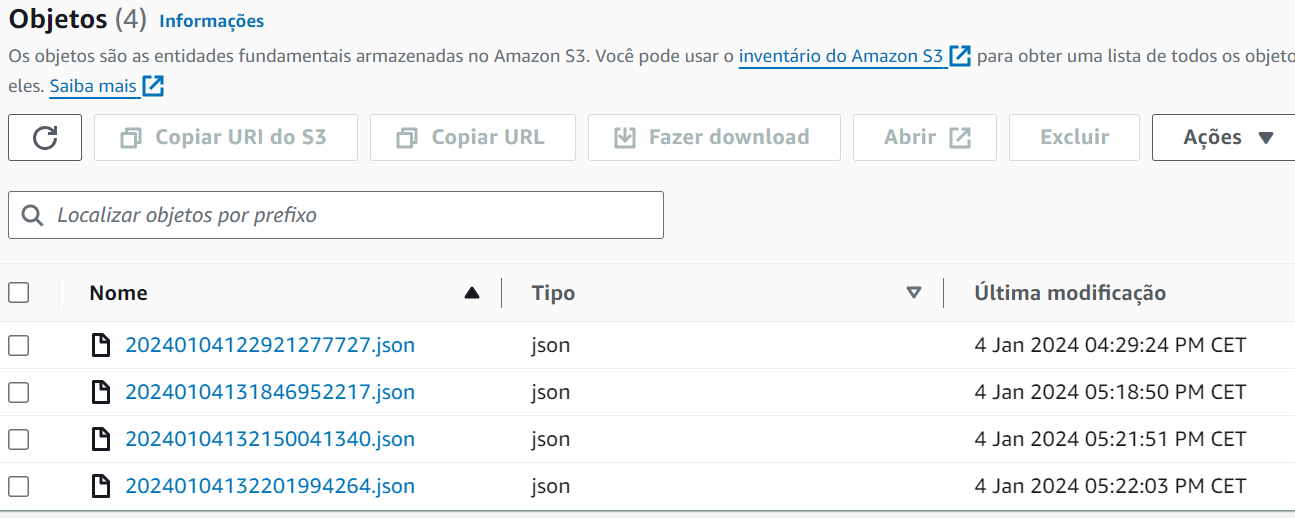

# **5. ETL**

A etapa de **extração, transformação e carregamento** (do inglês extraction, transformation and load ou ETL) é uma etapa abrangente responsável pela manipulação dos dados ingeridos de sistemas transacionais, ou seja, já persistidos em camadas cruas ou raw de sistemas analíticos.

Nesta etapa do projeto, vamos compactar as mensagens de um único dia em um arquivo, orientado a coluna e comprimido, onde será persistido em uma camada enriquecida. Além disso, durante este processo, o dado também passará por etapas de **data wrangling**. Para isso, utilizamos uma função do `AWS Lambda `como motor de processamento e um bucket do AWS S3 como camada enriquecida para a persistência do dado processado. Para garantir a recorrência, vamos configurar uma regra do `AWS Event Bridge` como gatilho diáro da função.



### **5.1 AWS S3, Lambda e Event Bridge**

* **Criamos um bucket no `AWS S3` para o armazenamento de dados enriquecidos.**




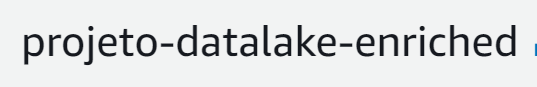

### **5.2 AWS Lambda**

* **Criamos uma função no `AWS Lambda` para processar as mensagens JSON de uma única partição do dia anterior (D-1), armazenadas no bucket de dados crus. Salve o resultado em um único arquivo `PARQUET`, também particionado por dia.**
* **Configurando as variáveis de ambiente, adicionando as permissão de interação com AWS S3 no AWS IAM, de configurar o timeout e de adicionar a layer com o código do pacote Python PyArrow.**
*  **Para a função, aumentamos o tempo para 5 minutos, principalmente para lidar com o IO (input/output) de arquivos do AWS S3.**

In [ ]:
# Código da função

import os
import json
import logging
from datetime import datetime, timedelta, timezone

import boto3
import pyarrow as pa
import pyarrow.parquet as pq


def lambda_handler(event: dict, context: dict) -> bool:

  '''
  Diariamente é executado para compactar as diversas mensagensm, no formato
  JSON, do dia anterior, armazenadas no bucket de dados cru, em um único
  arquivo no formato PARQUET, armazenando-o no bucket de dados enriquecidos
  '''

  # vars de ambiente

  RAW_BUCKET = os.environ['AWS_S3_BUCKET']
  ENRICHED_BUCKET = os.environ['AWS_S3_ENRICHED']

  # vars lógicas

  tzinfo = timezone(offset=timedelta(hours=-3))
  date = (datetime.now(tzinfo) - timedelta(days=1)).strftime('%Y-%m-%d')
  timestamp = datetime.now(tzinfo).strftime('%Y%m%d%H%M%S%f')

  # código principal

  table = None
  client = boto3.client('s3')

  try:

      response = client.list_objects_v2(Bucket=RAW_BUCKET, Prefix=f'telegram/context_date={date}')

      for content in response['Contents']:

        key = content['Key']
        client.download_file(RAW_BUCKET, key, f"/tmp/{key.split('/')[-1]}")

        with open(f"/tmp/{key.split('/')[-1]}", mode='r', encoding='utf8') as fp:

          data = json.load(fp)
          data = data["message"]

        parsed_data = parse_data(data=data)
        iter_table = pa.Table.from_pydict(mapping=parsed_data)

        if table:

          table = pa.concat_tables([table, iter_table])

        else:

          table = iter_table
          iter_table = None

      pq.write_table(table=table, where=f'/tmp/{timestamp}.parquet')
      client.upload_file(f"/tmp/{timestamp}.parquet", ENRICHED_BUCKET, f"telegram/context_date={date}/{timestamp}.parquet")

      return True

  except Exception as exc:
      logging.error(msg=exc)
      return False

In [ ]:
# Código da função de data wrangling

def parse_data(data: dict) -> dict:

  date = datetime.now().strftime('%Y-%m-%d')
  timestamp = datetime.now().strftime('%Y-%m-%d %H:%M:%S')

  parsed_data = dict()

  for key, value in data.items():

      if key == 'from':
          for k, v in data[key].items():
              if k in ['id', 'is_bot', 'first_name']:
                parsed_data[f"{key if key == 'chat' else 'user'}_{k}"] = [v]

      elif key == 'chat':
          for k, v in data[key].items():
              if k in ['id', 'type']:
                parsed_data[f"{key if key == 'chat' else 'user'}_{k}"] = [v]

      elif key in ['message_id', 'date', 'text']:
          parsed_data[key] = [value]

  if not 'text' in parsed_data.keys():
    parsed_data['text'] = [None]

  return parsed_data

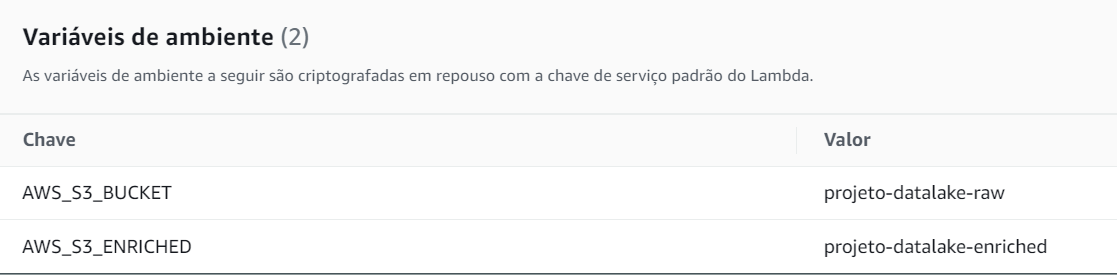

**Por fim, o código da função utiliza o pacote Python PyArrow. Contudo, o ambiente padrão do `AWS Lambda` não possui esse pacote externo instalado. Portanto, vamos adicionar esse pacote externo no ambiente do AWS Lambda, seguindos os passos abaixo:**

 - Criando um *bucket* no `AWS S3`;
 - Fazendo o *upload* do código do pacote Python do PyArrow (*download* neste [link](https://github.com/awslabs/aws-data-wrangler/releases));
 - Criando *layer* e conectar na função.

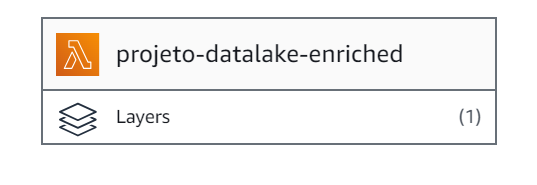

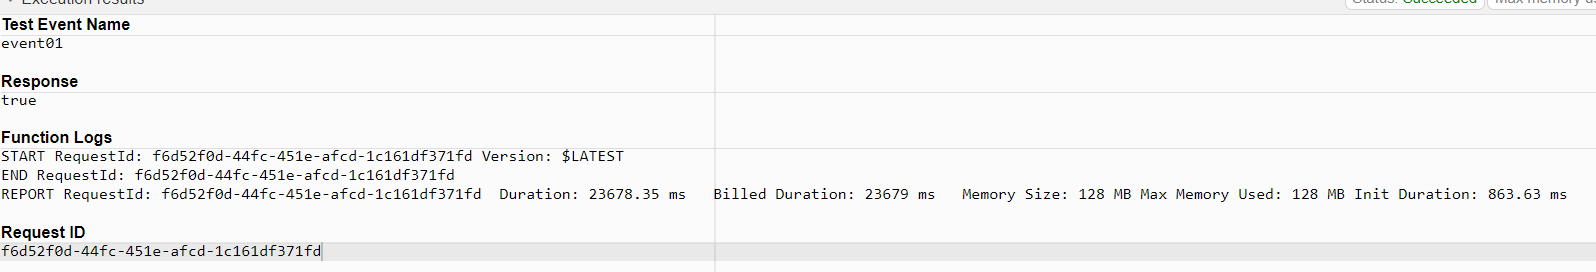

### **5.3 AWS Event Bridge**

* Criamos uma regra no **AWS Event Bridge** para executar a função do AWS Lambda todo dia a meia noite no horário (UTC+1).

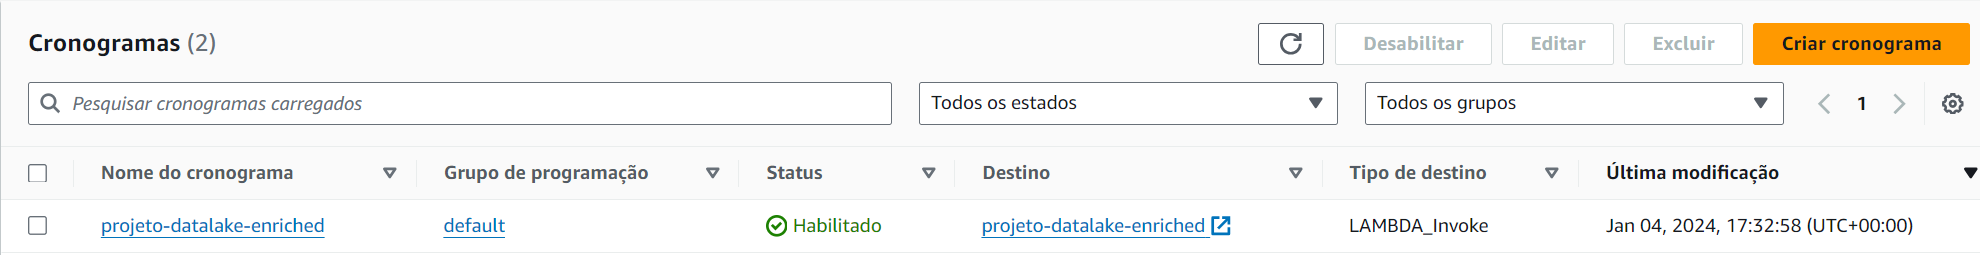

# **6. Apresentação**

O `AWS Athena` tem função de entregar o dados através de uma interface SQL para os usuários do sistema analítico. Nesta etapa de apresentação, vamos criar  uma tabela externa sobre o dado armazenado na camada mais refinada da arquitetura, a camada enriquecida.


```sql
CREATE EXTERNAL TABLE `telegram`(
  `message_id` bigint,
  `user_id` bigint,
  `user_is_bot` boolean,
  `user_first_name` string,
  `chat_id` bigint,
  `chat_type` string,
  `text` string,
  `date` bigint)
PARTITIONED BY (
  `context_date` date)
ROW FORMAT SERDE
  'org.apache.hadoop.hive.ql.io.parquet.serde.ParquetHiveSerDe'
STORED AS INPUTFORMAT
  'org.apache.hadoop.hive.ql.io.parquet.MapredParquetInputFormat'
OUTPUTFORMAT
  'org.apache.hadoop.hive.ql.io.parquet.MapredParquetOutputFormat'
LOCATION
  's3://<bucket-enriquecido>/'
```

* **Por fim, adicionar as partições disponíveis e onsultar as 10 primeiras linhas para observar o resultado.**

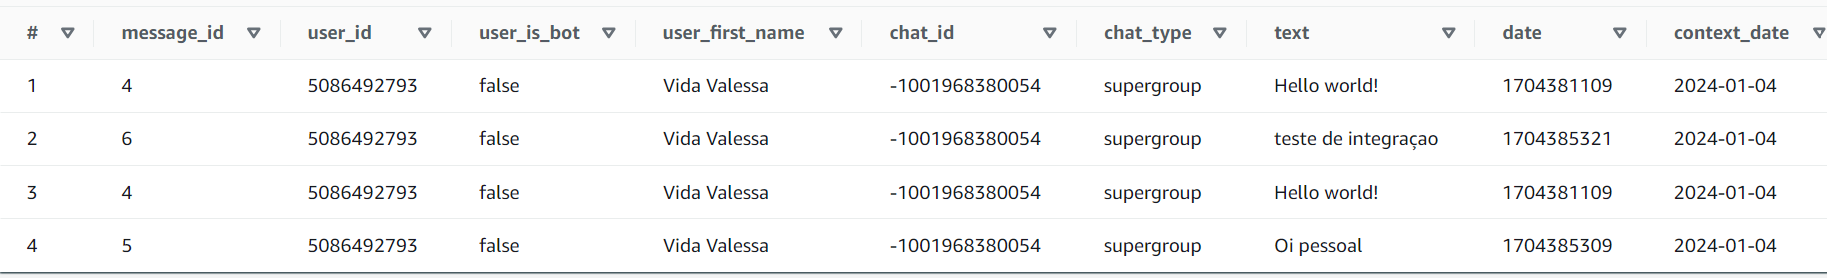